# Fitting a GP on 2D Poisson Data with SVI

Much of the code doesn't change from the previous notebook. We implement subsampling immediately to speed up our fits. We consider two cases: fixed inducing points and floating inducing points that are optimized together with the GP hyperparameters.

In [95]:
# necessary packages
import sys
sys.path.append("..")
from utils import custom
from utils.custom import log_like_poisson

import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl
import tqdm

import jax # for faster numerical operations
import jax.numpy as jnp # for numpy-like syntax
from jax.scipy import stats
from jax.scipy.special import logit, expit
from jax import jit

from tinygp import GaussianProcess, kernels
import numpyro # for inference and probabilistic programming
import numpyro.distributions as dist
from numpyro.infer import Predictive

## Generate 2D Poisson Data

Text(0.5, 1.0, 'True Rate')

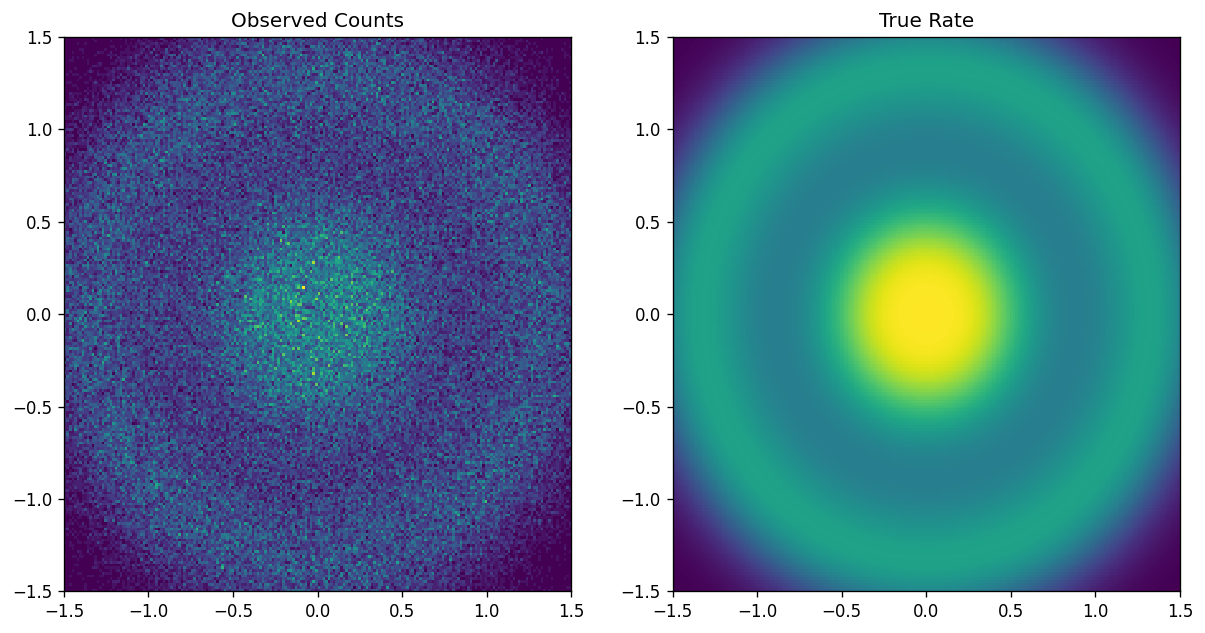

In [96]:
# plot the true function
x1_plt = jnp.linspace(-1.5, 1.5, 201)
x2_plt = jnp.linspace(-1.5, 1.5, 201)
x1_c = 0.5 * (x1_plt[1:] + x1_plt[:-1]) ; x2_c = 0.5 * (x2_plt[1:] + x2_plt[:-1])
x1, x2 = jnp.meshgrid(x1_c, x2_c)
x = jnp.stack([x1, x2], axis=-1)
x_mag = jnp.linalg.norm(x, axis = -1)
log_rate = -0.6 * x_mag**2. * jnp.abs(1.5 + jnp.cos(8. * x_mag**(0.5)))
rate = 10 * jnp.exp(log_rate)
y = rate

# add poisson noise
y_obs = jax.random.poisson(jax.random.PRNGKey(23),y) 

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)
ax.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis')
ax.set_title('Observed Counts')

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, rate, cmap='viridis')
ax.set_title('True Rate')

## 1D Slice of Poisson Data and Rate

Text(0, 0.5, 'y')

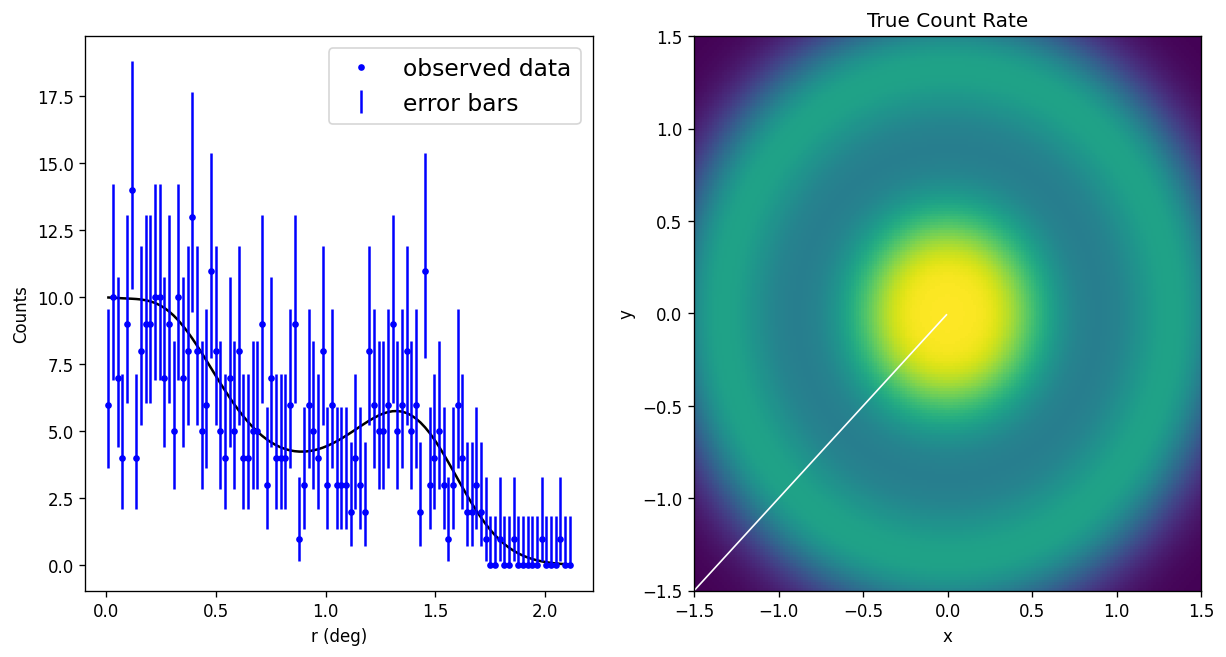

In [97]:
# Plot fit curves on a slice of x-values

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)
ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
yerr = jnp.array([custom.poisson_interval(k) for k in y_obs[ny,ny].T]).T
ax.errorbar(r, y_obs[ny,ny], yerr = yerr, c = 'b', fmt = 'none', label='error bars')
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=np.max(y)))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [98]:
# for defining a 2D Gaussian Process, need to reshape data into 1D arrays
# KEY: shape must be of the form (N_data, ) NOT (N_data) or (N_data, 1))   
x_f = x.reshape((-1,2))
y_obs_f = y_obs.reshape((-1,))

## GP Fit with Fixed Inducing Points
You are free to pick any set of inducing points you want. So you can ensure the inducing points "communicate" with one another, I prefer choosing inducing points that are roughly equidistant to one another. 

For simplicity, we consider a square grid.

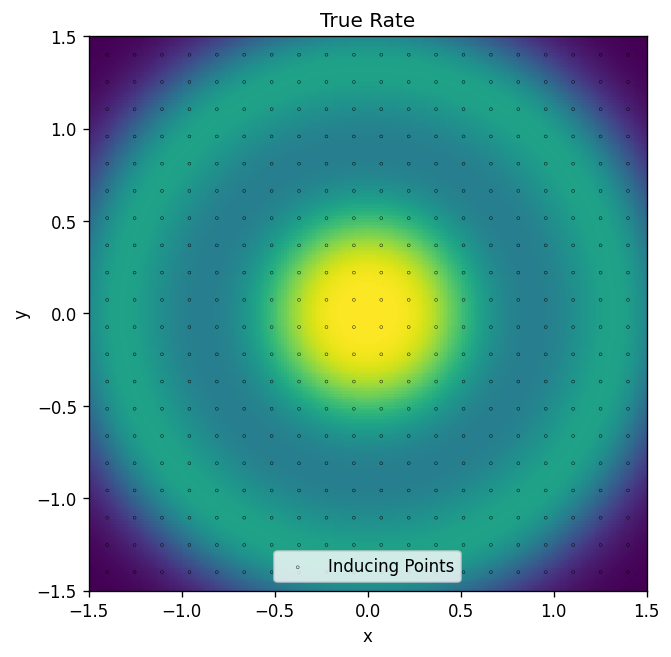

In [99]:
# create mesh grid of x and y inducing point locations
xu1_plt = np.linspace(-1.4, 1.4, 20) ; xu2_plt = np.linspace(-1.4, 1.4, 20)
xu1, xu2 = jnp.meshgrid(xu1_plt, xu2_plt)
xu = jnp.stack([xu1, xu2], axis=-1)
xu_f = xu.reshape((-1,2))

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

ax.pcolormesh(x1_plt, x2_plt, rate, cmap='viridis')
ax.set_title('True Rate')
ax.scatter(xu_f[:,0], xu_f[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25, label = 'Inducing Points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

In [100]:
def model(x, xu, y=None, gp_rng_key = jax.random.PRNGKey(0)):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)  ; shape: (Nx, Ndim)
    xu : array
        x values of inducing points ; shape: (Nu, Ndim)
    y : array
        y values (observations) ; shape: (Nx, )
    gp_rng_key : PRNGKey
        random key for sampling from GP
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define GP on inducing points
    gp_u = GaussianProcess(kernel, xu, diag = 1e-3)
    log_rate_u = numpyro.sample("log_rate_u", gp_u.numpyro_dist())
    
    # sample GP at x from inducing point samples with subsampling
    with numpyro.plate('data', size=len(x), dim=-1, subsample_size=512) as ind:
        _, gp_x = gp_u.condition(log_rate_u, x[ind], diag=1e-3)
        log_rate = gp_x.sample(key = gp_rng_key)
        rate = jnp.exp(log_rate)
    
    # load function values and compute log likelihood
    numpyro.factor("log_likelihood", log_like_poisson(rate, y[ind])) 

In [101]:
# run SVI
svi, guide = custom.load_svi(model, lr = 0.005, num_particles = 8)
rng_key = jax.random.PRNGKey(0)
svi_results = custom.svi_loop(rng_key, 20000, svi, x_f, xu_f, y_obs_f)

100%|██████████| 20000/20000 [02:23<00:00, 138.92it/s]


In [102]:
# though we sped up the fit, it is still to resource-intensive to define sample from a GP over the full input space
# as a result, we sample on a lower-resolution grid

# define a lower-resolution grid to create map of Poisson rate

res_scale = 2 # reduce resolution by this factor

Nx1 = x1_c.shape[0]
Nx2 = x2_c.shape[0]

c1_plt = jnp.linspace(-1.5, 1.5, int(Nx1 / res_scale) + 1)
c2_plt = jnp.linspace(-1.5, 1.5, int(Nx2 / res_scale) + 1)
c1_c = 0.5 * (c1_plt[1:] + c1_plt[:-1]) ; c2_c = 0.5 * (c2_plt[1:] + c2_plt[:-1])
c1, c2 = jnp.meshgrid(c1_c, c2_c)
c = jnp.stack([c1, c2], axis=-1)
c_f = c.reshape((-1,2))

In [103]:
# sample the GP at x using custom (vectorized) sampler
rng_key, key = jax.random.split(rng_key)
pred = Predictive(guide, num_samples = 1, params = svi_results.params)
gp_samples = custom.get_gp_samples_at_x_from_u(rng_key, 1000, pred, svi_results.params, c_f, xu_f)

Text(0.5, 1.0, 'Counts')

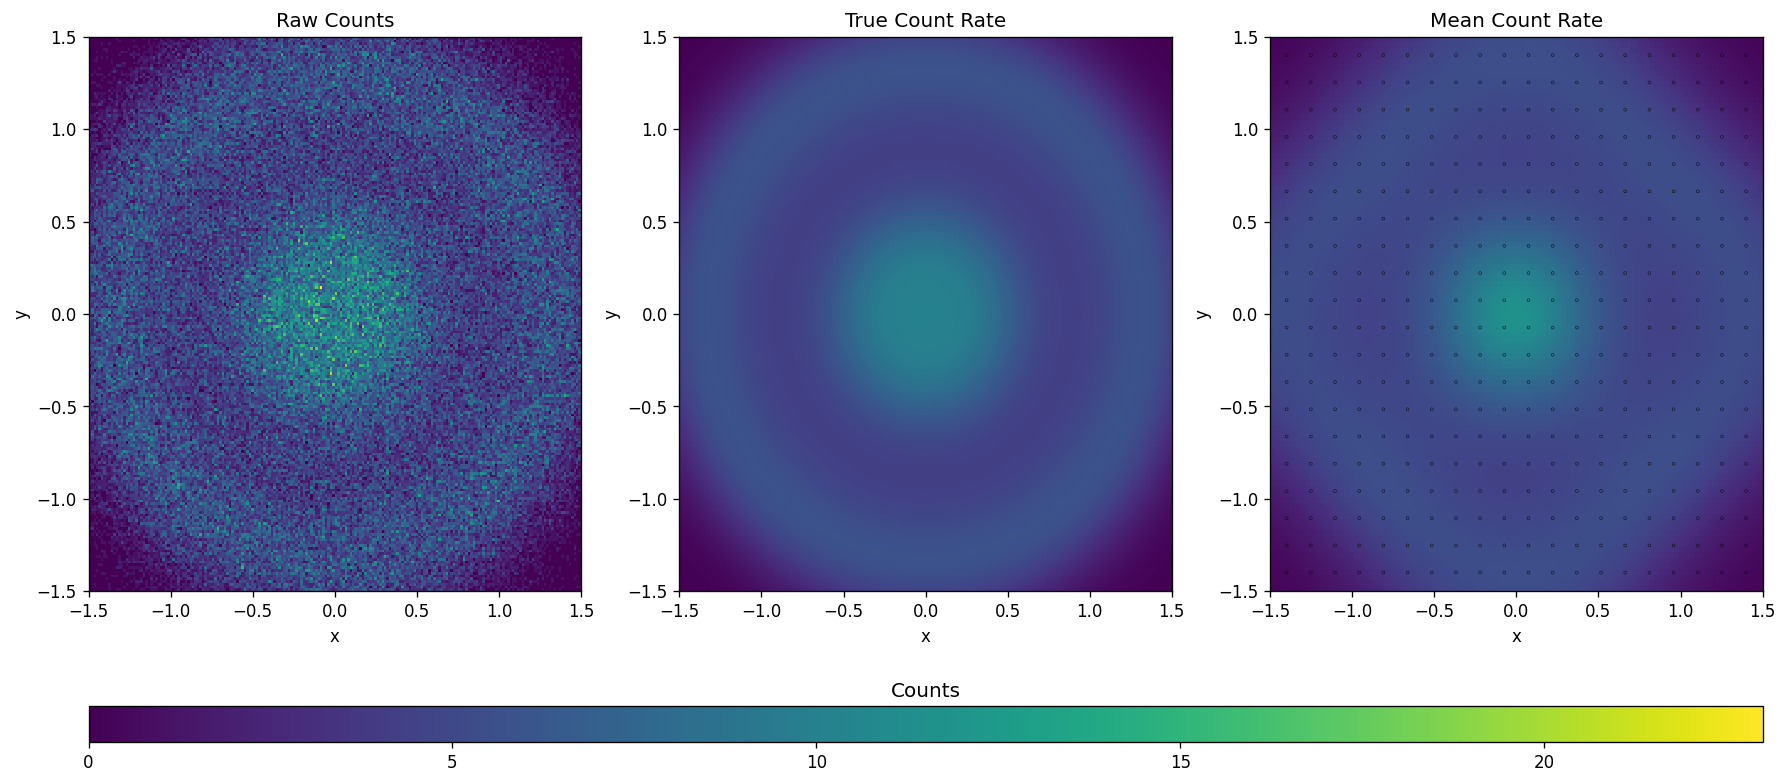

In [104]:
q = np.percentile(jnp.exp(gp_samples), [5,50,95], axis = 0)
q = q.reshape((3,c1_c.shape[0], c2_c.shape[0])).copy() # reshape to grid

# plot raw count map, true rate map, and mean rate map from posterior of log_rate

import matplotlib as mpl

vmax = np.max([np.max(y_obs), np.max(y), np.max(jnp.exp(gp_samples))])
fig = plt.figure(figsize=(18, 6), dpi= 120)
ax1 = fig.add_subplot(131)
plot1 = plt.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax1.set_title('Raw Counts')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig.add_subplot(132)
plot2 = plt.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax2.set_title('True Count Rate')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax3 = fig.add_subplot(133)
plot3 = plt.pcolormesh(c1_plt, c2_plt, q[1], cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax3.set_title('Mean Count Rate')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.scatter(xu_f[:,0], xu_f[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)

p0 = ax1.get_position().get_points().flatten()
p1 = ax2.get_position().get_points().flatten()
p2 = ax3.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.1, p2[2]-p0[0], 0.05])

plt.colorbar(cax=ax_cbar, orientation='horizontal')
ax_cbar.set_title('Counts')

Text(0, 0.5, 'y')

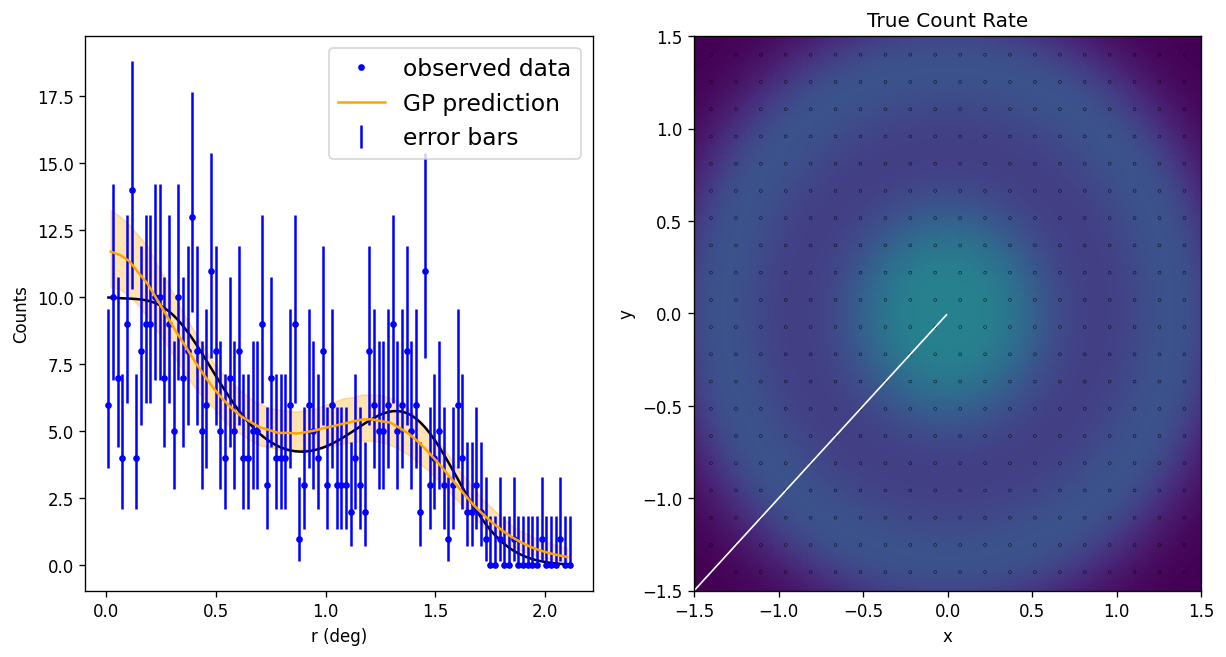

In [105]:
# Plot fit curves on a slice of increasing radius

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)

Ncx = len(c1_c)
ncy = np.arange(0,int(Ncx/2),1)
rc = np.linalg.norm(c[ncy,ncy,:], axis = -1)


ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
yerr = jnp.array([custom.poisson_interval(k) for k in y_obs[ny,ny].T]).T
ax.errorbar(r, y_obs[ny,ny], yerr = yerr, c = 'b', fmt = 'none', label='error bars')
ax.plot(rc, q[1][ncy,ncy], c = 'orange', label = 'GP prediction')
ax.fill_between(rc, q[0][ncy,ncy], q[2][ncy,ncy], color = 'orange', alpha = 0.3)
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.scatter(xu_f[:,0], xu_f[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

## Floating Inducing Points
To ensure our inducing point locations $x_u$ are confined to the observation region, we define them as outputs of a sigmoid function. To clarify, the x-coordinates are given by
$$ x_u = x_{min} + (x_{max} - x_{min}) \sigma (t_{1}), $$
with a similar definition for the y-coordinates.

### Initial Set of Inducing Point Locations

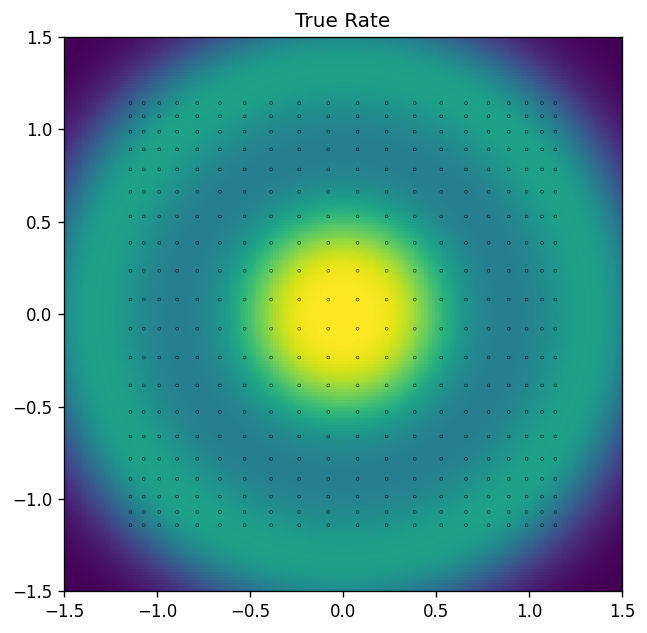

In [106]:
Nu = 400
sNu = jnp.sqrt(Nu).astype(int)
t = jnp.linspace(-2,2,sNu)
t1 = jnp.concatenate([t for i in range(sNu)])
t2 = jnp.array(jnp.concatenate([t[n] * jnp.ones(sNu) for n in range(sNu)]))
tu = [t1,t2]

xu = -1.5 + 3. * expit(t1)
yu = -1.5 + 3. * expit(t2)

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

ax.pcolormesh(x1_plt, x2_plt, rate, cmap='viridis')
ax.set_title('True Rate')
ax.scatter(xu, yu, facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)

In [107]:
def model(x, tu, y=None, gp_rng_key = jax.random.PRNGKey(0)):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)  ; shape: (Nx, Ndim)
    y : array
        y values (observations) ; shape: (Nx, )
    gp_rng_key : PRNGKey
        random key for sampling from GP
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # floating inducing points
    logit_xu, logit_yu = tu

    # generate initial inducing points 
    lxu = numpyro.param(
        "lxu", logit_xu
    )

    lyu = numpyro.param(
        "lyu", logit_yu
    )

    xu = -1.5 + 3. * expit(lxu)
    yu = -1.5 + 3. * expit(lyu)

    xu_f = jnp.vstack([xu.T,yu.T]).T

    # define GP on inducing points
    gp_u = GaussianProcess(kernel, xu_f, diag = 1e-3)
    log_rate_u = numpyro.sample("log_rate_u", gp_u.numpyro_dist())
    
    # sample GP at x from inducing point samples with subsampling
    with numpyro.plate('data', size=len(x), dim=-1, subsample_size=512) as ind:
        _, gp_x = gp_u.condition(log_rate_u, x[ind], diag=1e-3)
        log_rate = gp_x.sample(key = gp_rng_key)
        rate = jnp.exp(log_rate)
    
    # load function values and compute log likelihood
    numpyro.factor("log_likelihood", log_like_poisson(rate, y[ind])) 

In [108]:
# run SVI
svi, guide = custom.load_svi(model, lr = 0.005, num_particles = 8)
rng_key = jax.random.PRNGKey(0)
svi_results = custom.svi_loop(rng_key, 20000, svi, x_f, tu, y_obs_f)

100%|██████████| 20000/20000 [02:39<00:00, 125.63it/s]


In [109]:
# load optimized inducing points to extrapolate to full input space
lxu = svi_results.params["lxu"]
lyu = svi_results.params["lyu"]

xu = -1.5 + 3. * expit(lxu)
yu = -1.5 + 3. * expit(lyu)

xu_f = jnp.vstack([xu.T,yu.T]).T

In [110]:
# sample the GP at x using custom (vectorized) sampler
rng_key, key = jax.random.split(rng_key)
pred = Predictive(guide, num_samples = 1, params = svi_results.params)
gp_samples = custom.get_gp_samples_at_x_from_u(rng_key, 1000, pred, svi_results.params, c_f, xu_f)

Text(0.5, 1.0, 'Counts')

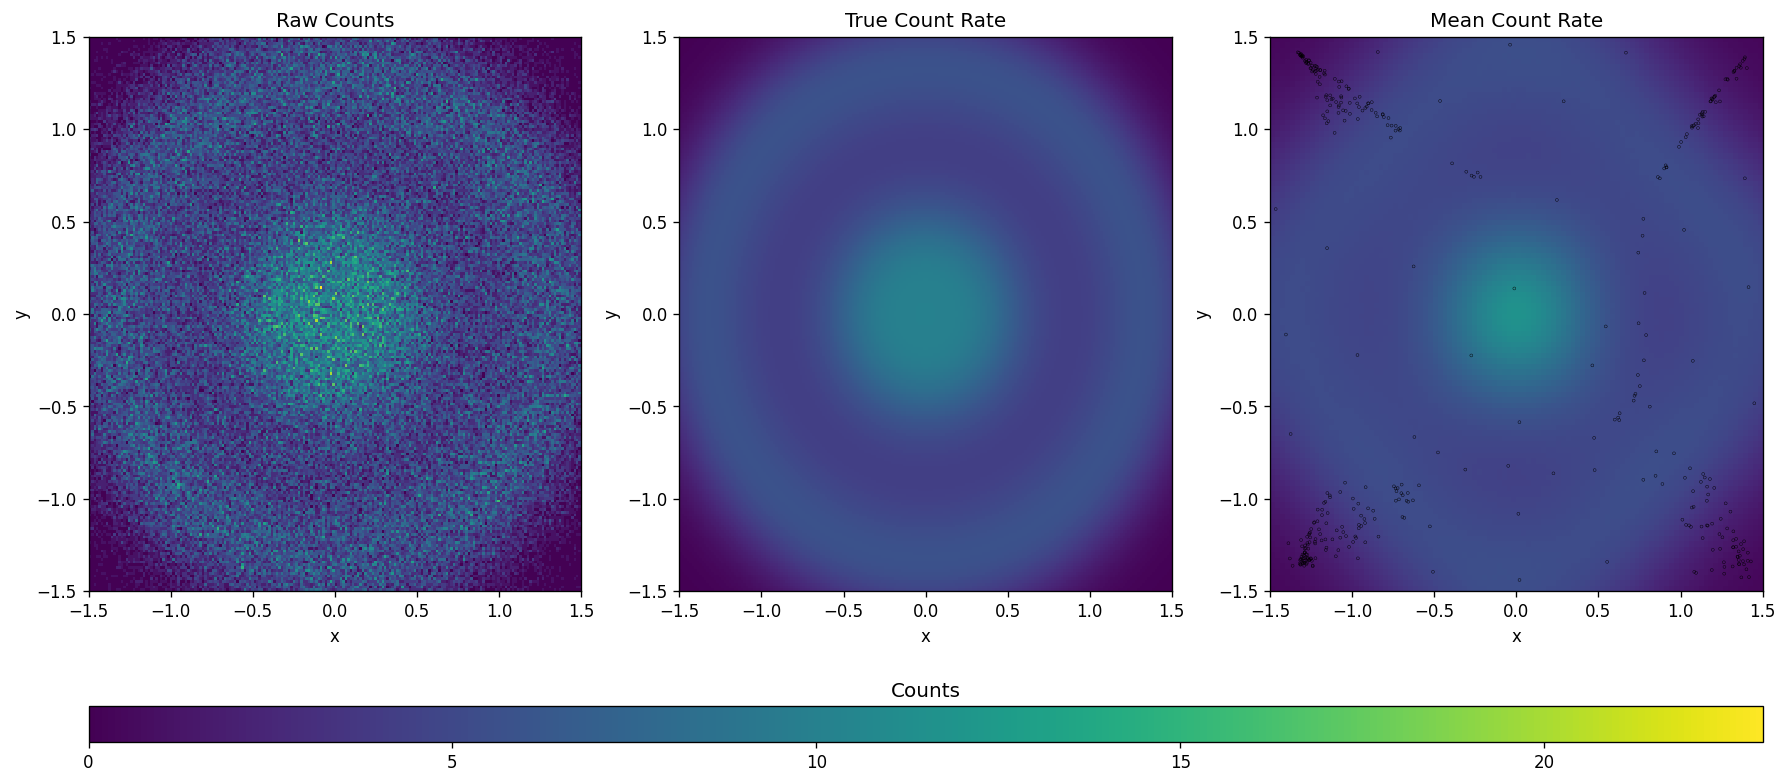

In [111]:
q = np.percentile(jnp.exp(gp_samples), [5,50,95], axis = 0)
q = q.reshape((3,c1_c.shape[0], c2_c.shape[0])).copy() # reshape to grid

# plot raw count map, true rate map, and mean rate map from posterior of log_rate

import matplotlib as mpl

vmax = np.max([np.max(y_obs), np.max(y), np.max(jnp.exp(gp_samples))])
fig = plt.figure(figsize=(18, 6), dpi= 120)
ax1 = fig.add_subplot(131)
plot1 = plt.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax1.set_title('Raw Counts')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig.add_subplot(132)
plot2 = plt.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax2.set_title('True Count Rate')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax3 = fig.add_subplot(133)
plot3 = plt.pcolormesh(c1_plt, c2_plt, q[1], cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax3.set_title('Mean Count Rate')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.scatter(xu_f[:,0], xu_f[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)

p0 = ax1.get_position().get_points().flatten()
p1 = ax2.get_position().get_points().flatten()
p2 = ax3.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.1, p2[2]-p0[0], 0.05])

plt.colorbar(cax=ax_cbar, orientation='horizontal')
ax_cbar.set_title('Counts')

Text(0, 0.5, 'y')

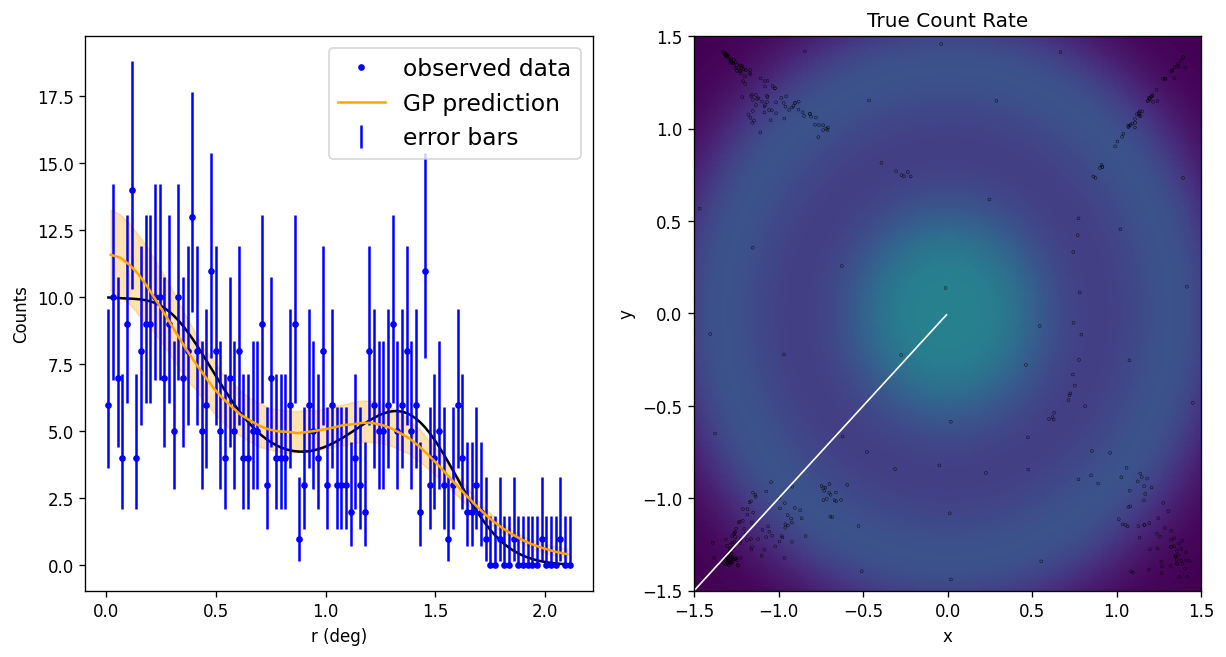

In [112]:
# Plot fit curves on a slice of increasing radius

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)

Ncx = len(c1_c)
ncy = np.arange(0,int(Ncx/2),1)
rc = np.linalg.norm(c[ncy,ncy,:], axis = -1)


ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
yerr = jnp.array([custom.poisson_interval(k) for k in y_obs[ny,ny].T]).T
ax.errorbar(r, y_obs[ny,ny], yerr = yerr, c = 'b', fmt = 'none', label='error bars')
ax.plot(rc, q[1][ncy,ncy], c = 'orange', label = 'GP prediction')
ax.fill_between(rc, q[0][ncy,ncy], q[2][ncy,ncy], color = 'orange', alpha = 0.3)
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.scatter(xu_f[:,0], xu_f[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

As you can see, it is difficult to interpret why the GP chose those inducing point locations. They seem to make the GP highly degenerate.